# Agent Learning Using TD(0) 

Consider an agent **A** which is using MCTS and neural network *N* to find the
best move.

This algorithm works as follows: play *M* games, recording new state, previous state, the decision, expected reward and the reward after each move (in the expert memory).

In the training loop, sample *k* moves from the memory (experience replay), compute the loss between *N(s)* and expected reward and update the params of the network.

In [38]:
config = {
    "Algorithm": "TD(0)",
    "Episode Games": 10,
    "Sample Size": 64,
    "NN": "v1_cnn(1)_cat_lines"
}

In [39]:
%load_ext autoreload
%autoreload 2

%pip install -Uq pip
%pip install install --quiet 'git+https://github.com/balgot/mathematico.git#egg=mathematico&subdirectory=game'
%pip install -q torch torchview torchsummary graphviz

import torch
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


device(type='cpu')

In [ ]:
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))

import mathematico
from src.utils import mcts

### Neural Network Definition

As the input, the network takes `list[list[int]]` - the board and the card number of type `int`, and it approximates the value function `V(s) = V((board, card))`.

All inputs are one-hot encoded.

starting with cc torch.Size([32])
starting with bb torch.Size([32, 5, 5])


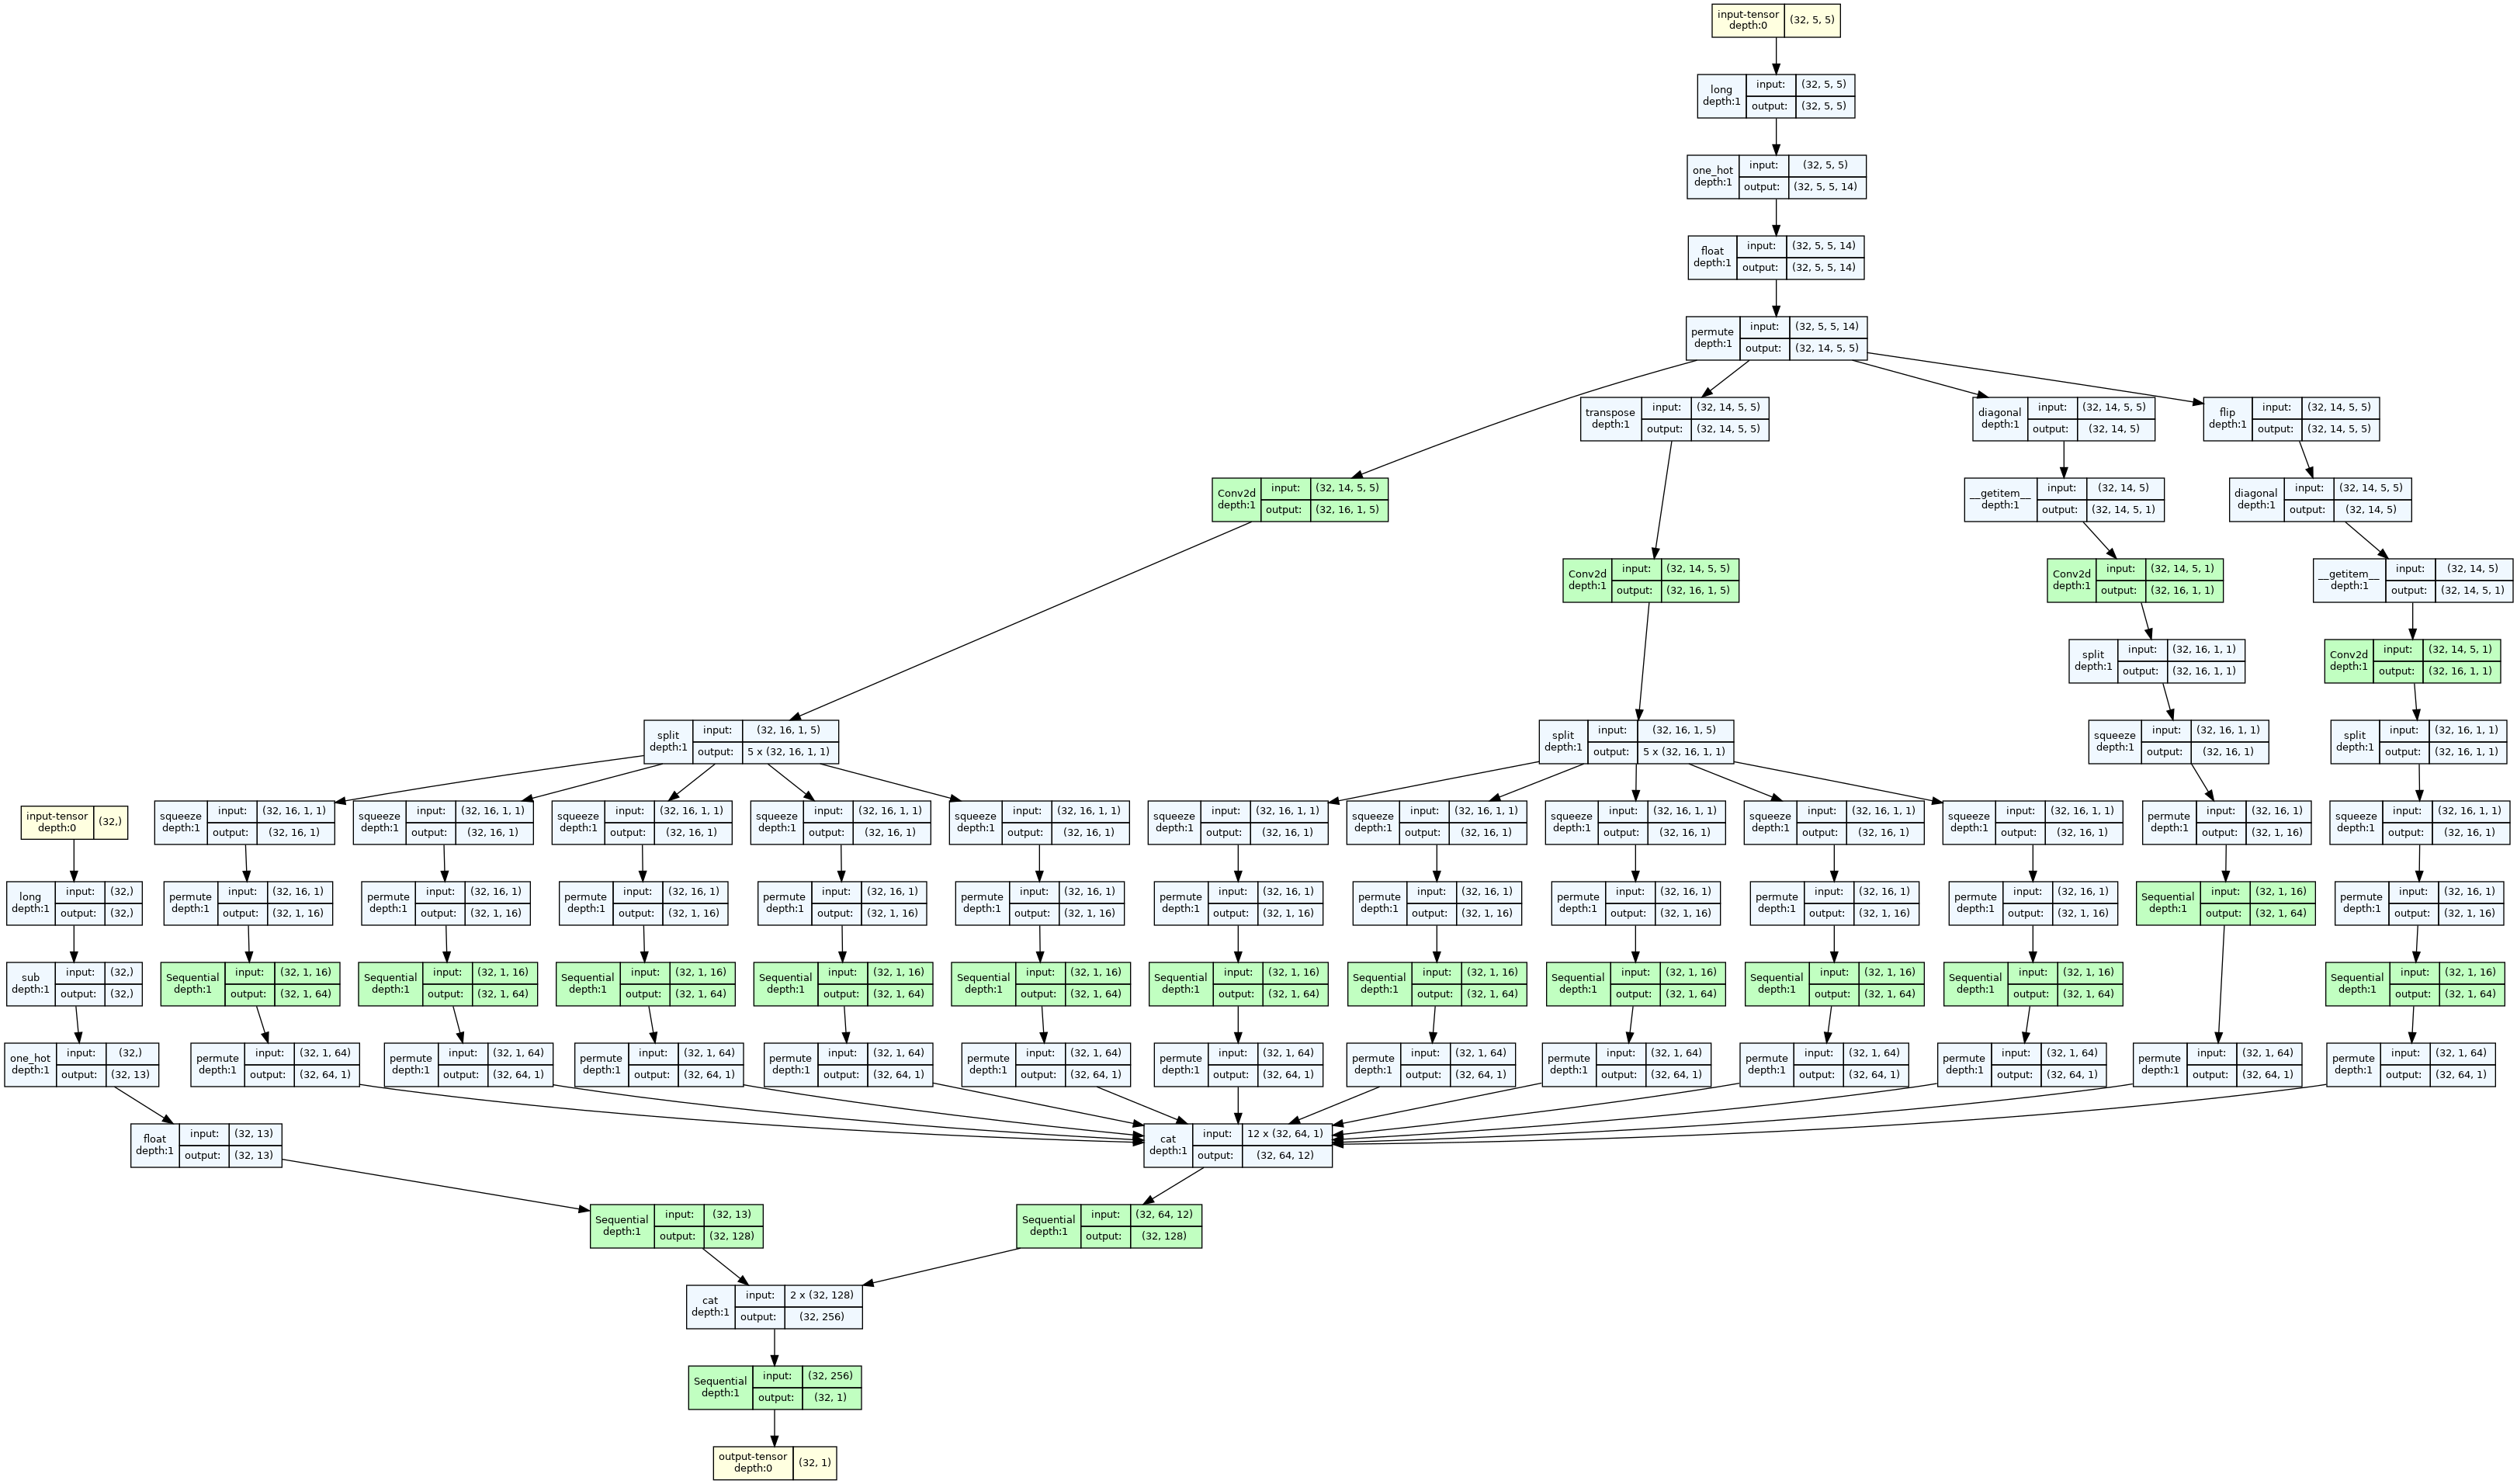

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math


BOARD_SIZE = 5
AVAILABLE_CARDS = 13
BOARD_CARDS = AVAILABLE_CARDS + 1  # for no card


class NNv1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Conv2d(in_channels=BOARD_CARDS, out_channels=16, kernel_size=(5, 1), padding=0)  # feature extractor
        self.line_proc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )  # line processor


        self.card_proc = nn.Sequential(
            nn.Linear(AVAILABLE_CARDS, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Flatten(start_dim=1)
        )  # card block

        self.mix_lines = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (5 + 5 + 2), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )  # combine lines

        self.out = nn.Sequential(
            nn.Linear(128 + 128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )  # card-board mix

    def forward(self, board: torch.Tensor, card: torch.Tensor):
        """
        board = torch.tensor([[1,1,1,1], [1,1,1,1], ...]) -- BATCH_SIZE, 5, 5
        card = torch.tensor(card) -- BATCH_SIZE
        """

        # Analysing the current card
        card = F.one_hot(card.long() - 1, num_classes=AVAILABLE_CARDS).float()
        card = self.card_proc(card)

        # The board features
        board = F.one_hot(board.long(), num_classes=BOARD_CARDS).float()  
        board = board.permute(0, 3, 1, 2) # permute dimensions to match expected order
        # print(f"permuted board shape = {board.shape}")

        # rows of the board
        rows = self.features(board)
        # print(f"rows shape = {rows.shape}")

        # cols of the board        
        cols = self.features(board.transpose(-1, -2)) # TODO: makes sence?
        # print(f"cols shape = {cols.shape}")

        # main/anti diagonal
        main = board.diagonal(0, -2, -1)[:, :, :, None]
        anti = torch.flip(board, [-2, -1]).diagonal(0, -2, -1)[:, :, :, None]
        # print(f"*diag shape {main.shape}")
        # print(f"*anti shape {anti.shape}")
        main = self.features(main)
        anti = self.features(anti)
        # print(f"diag shape {main.shape}")
        # print(f"anti shape {anti.shape}")

        # combine the features
        combined = []
        for tensor in (rows, cols, main, anti):
            spl = torch.split(tensor, 1, dim=3)
            for t in spl:
                t = t.squeeze(dim=3)
                t = t.permute(0, 2, 1)
                t = self.line_proc(t)
                t = t.permute(0, 2, 1)
                combined.append(t)

        board = torch.cat(combined, dim=-1)
        # print(f"cat shape {board.shape}")
        board = self.mix_lines(board)
        # print(f"mixed lines shape {board.shape}")

        # combine
        comb = torch.cat([board, card], dim=-1)
        # print(f"combined {comb.shape}")

        # out
        out = self.out(comb)
        # print(f"out shape {out.shape}")

        return out


from torchview import draw_graph

# VS code fix for cropped images
import graphviz
graphviz.set_jupyter_format('png')

model = NNv1()# .to(dev)
BOARD = [[1] * 5] * 5
CARD = 1
BSIZE = 32

bb = [BOARD] * BSIZE
cc = [CARD] * BSIZE
bb = torch.tensor(bb)# .to(dev)
cc = torch.tensor(cc)# .to(dev)

print(f"starting with cc {cc.shape}")
print(f"starting with bb {bb.shape}")

model.forward(bb, cc)


display(draw_graph(model, input_data=(bb, cc), depth=1, expand_nested=True).visual_graph)

### Weight & Biases Initialisation

In [ ]:
%pip install -q wandb
import wandb

Note: you may need to restart the kernel to use updated packages.


In [ ]:
wandb.init(config=config, project="PA026")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 485135 (miba). Use `wandb login --relogin` to force relogin


### Agent

In [ ]:
from typing import Tuple, Sequence, List
from copy import deepcopy
from mathematico import Board
from random import randrange
from collections import Counter



# The action type (row and col to play)
Action = Tuple[int, int]

# The card we are supposed to place on the board
Card = int

# For representing the available cards, card ↦ number of cards in the deck
Deck = dict[Card, int]


class MathematicoState(mcts.StateI):
    """
    State of the game, represented by the positions
    of the cards already placed on the board and the card
    to place.
    """

    def __init__(self, board: Board, number: Card, cards_left: 'Deck | None' = None):
        self.board: Board = board
        self.number: Card = number
        self.deck = cards_left

        # count the number of cards available
        if self.deck is None:
            self.deck = {i: 4 for i in range(1, 14)}
            for row in range(board.size):
                for col in range(board.size):
                    num = board.grid[row][col]
                    if num != 0:
                        assert num in self.deck, f"{num=} {row=} {col=} {board=}"
                        self.deck[num] -= 1
                        if not self.deck[num]:
                            self.deck.pop(num)
        
        assert number in self.deck, f"{number=} {cards_left=}"

    def get_possible_actions(self) -> Sequence[Action]:
        return list(self.board.possible_moves())

    def take_action(self, action: Action) -> 'list[tuple[mcts.StateI, float]]':
        cnt = sum(self.deck.values()) - 1  # one card is eliminated anyways
        res = []

        # find all possible states after playing card: self.number at position action
        for card, n in self.deck.items():
            if card == self.number and n == 1:
                continue
            board = deepcopy(self.board)
            board.make_move(action, self.number)  # take action that leads TO this state
            deck = deepcopy(self.deck) # .copy()  # enough for int ↦ int
            deck[self.number] -= 1
            if not deck[self.number]:
                deck.pop(self.number)
            res.append((MathematicoState(board, card, deck), n / cnt))
        return res

    def is_terminal(self) -> bool:
        return self.board.occupied_cells == self.board.size ** 2

    def get_reward(self):
        return self.board.score()



# POLICY
def _VNN_policy(state: MathematicoState):
    board = torch.tensor([state.board.grid])
    card = torch.tensor([state.number])
    return model(board, card)



class MctsPlayer(mathematico.Player):
    def __init__(self, max_time, max_iters):
        super().__init__()
        self._mcts = mcts.MCTS(time_limit=max_time, iters_limit=max_iters, rollout_policy=_VNN_policy)
    
    def reset(self) -> None:
        self.board = Board()

    def best_move(self, number):
        state = MathematicoState(self.board, number)
        action, value = self._mcts.search(state)[0]
        return action, value

    def play_move(self, move, number):
        self.board.make_move(move, number)

    def move(self, number: int):
        action, value = self.best_move(number)
        # print(f"[info] Expecting value: {value}\tFor action: {action}")        
        self.play_move(action, number)

### Playing simple game

In [ ]:
%%time

import random
random.seed(0)

arena = mathematico.Arena()
SIMULS = [10]

for simuls in SIMULS:
    player = MctsPlayer(None, max_iters=simuls)
    arena.add_player(player)

arena.run(seed=1, rounds=1)

Steps run: 1	Elapsed time: 1.0117943286895752
CPU times: user 4 s, sys: 113 µs, total: 4 s
Wall time: 1.01 s


[[80]]

### TD(0)

#### Utils

In [53]:
import statistics
%pip install -q tqdm
from tqdm.notebook import trange, tqdm
import random


optimizer = torch.optim.Adam(model.parameters())


def _test_performance(agent, model, rounds=10, verbose=False):
    model.eval()

    # exactly same implementation of arena but with tqdm
    import time
    class _Arena(mathematico.Arena):
        def run(self, rounds: int = 100, verbose: bool = False, seed = None):
            start = time.time()
            for _ in trange(rounds, desc="Testing", leave=None, position=1):
                # initialize a new game
                game = mathematico.Mathematico(seed=seed)
                for player in self.players:
                    player.reset()
                    game.add_player(player)

                # play the game and collect rewards
                results = game.play(verbose=False)
                for idx, result in enumerate(results):
                    self.results[idx].append(result)

            if verbose:
                total_time = time.time() - start
                print(f"Steps run: {rounds}\tElapsed time: {total_time}")

            return self.results


    arena = _Arena()
    arena.add_player(agent)
    results = arena.run(rounds=rounds)

    # get the results
    results = results[0]
    if verbose:
        print(f"{results=}")

    # get the mean and stddev
    mean = statistics.mean(results)
    std = statistics.stdev(results)
    return mean, std


def learn_episode(agent: MctsPlayer, model: nn.Module, n_games, batch_size, m_training, gamma=0.9):
    expert_memory = []

    # playing phase
    model.eval()
    for game in trange(n_games, desc="Game playing phase", leave=None, position=1):
        # initialize the game
        agent.reset()
        cards = [i for i in range(1, 13+1) for _ in range(4)]
        random.shuffle(cards)

        # game memory
        states = []  # board, card pairs
        estimates = []
        rewards = []  # either next state estimate or the actual reward


        # play all the moves till the end
        for move in trange(5*5, desc="Playing moves", leave=None, position=2):
            state = deepcopy(agent.board.grid)
            card = cards[move]
            action, estimate = agent.best_move(card)
            states.append((state, card))
            estimates.append(estimate)

            if move != 0:
                rewards.append(gamma * estimate)

            
            agent.play_move(action, card)

        rewards.append(agent.board.score())

        # TODO?: propagate reward backwards
        for i in reversed(range(len(rewards) - 1)):
            rewards[i] += gamma * rewards[i+1]

        for s, e, r in zip(states, estimates, rewards):
            expert_memory.append((s, e, r))

    # learning phase, TODO: some random symmetries apply
    model.train()
    for train in trange(m_training, desc="Training loop", leave=None, position=1):
        batch = random.sample(expert_memory, batch_size)
        boards = []
        cards = []
        outs = []
        targets = []

        for s, e, r in batch:
            boards.append(s[0])
            cards.append(s[1])
            outs.append(e)
            targets.append(r)

        optimizer.zero_grad()
        _outputs = model(torch.tensor(boards), torch.tensor(cards))
        # print(f"[{_outputs.dtype}]({_outputs.shape}) {_outputs=}")
        loss = torch.sum((_outputs - torch.tensor(targets)) ** 2)
        # print(f"{loss=}")
        loss.backward()
        optimizer.step()


Note: you may need to restart the kernel to use updated packages.


#### One Round

In [54]:
%%time
player = MctsPlayer(None, max_iters=10)
def _report():
    mean, stdev = _test_performance(player, model, verbose=True)
    print(f"{mean=}\t{stdev=}")
    return mean, stdev


print("Before the training:")
_report()

learn_episode(player, model, n_games=10, batch_size=32, m_training=30)

print("After training one episode:")
_report();

Before the training:


Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[140, 50, 90, 50, 50, 70, 120, 20, 70, 70]
mean=73	stdev=35.605867181937555


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/30 [00:00<?, ?it/s]

After training one episode:


Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 80, 50, 90, 80, 70, 70, 80, 110, 60]
mean=77	stdev=16.36391694484477
CPU times: user 2min 10s, sys: 228 ms, total: 2min 10s
Wall time: 33.5 s


#### Multiple Rounds

In [55]:
%%time
print("Before the training:")
mean, stdev = _report()
wandb.log({"Epoch": 0, "Mean": mean, "Stdev": stdev})

for epoch in trange(100, desc="Epochs", leave=None):
    learn_episode(player, model, n_games=10, batch_size=32, m_training=100)
    mean, stdev = _report()
    wandb.log({"Epoch": epoch+1, "Mean": mean, "Stdev": stdev})
    

Before the training:


Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[40, 130, 70, 20, 140, 80, 160, 100, 80, 60]
mean=88	stdev=44.671641514002545


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 70, 90, 30, 130, 50, 80, 100, 60, 80]
mean=78	stdev=27.80887148615228


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 60, 130, 90, 90, 90, 60, 100, 100, 30]
mean=82	stdev=27.80887148615228


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 70, 60, 80, 90, 60, 60, 120, 70, 70]
mean=75	stdev=18.408935028645434


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 60, 40, 130, 70, 60, 70, 60, 70, 70]
mean=72	stdev=23.944379994757295


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 40, 130, 130, 60, 120, 80, 60, 90, 120]
mean=89	stdev=33.81321240777535


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 90, 90, 20, 70, 80, 40, 80, 80, 50]
mean=66	stdev=23.190036174568117


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 70, 60, 90, 120, 100, 130, 60, 100, 100]
mean=93	stdev=23.593784492248517


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 70, 120, 80, 110, 60, 60, 80, 100, 70]
mean=81	stdev=21.83269719175042


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 120, 60, 80, 60, 170, 90, 110, 70, 50]
mean=87	stdev=37.13339317768966


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 40, 60, 90, 100, 50, 70, 90, 100, 110]
mean=81	stdev=24.244128727957577


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 90, 70, 100, 130, 100, 60, 80, 40, 110]
mean=85	stdev=26.352313834736496


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[50, 70, 90, 110, 100, 110, 70, 60, 80, 140]
mean=88	stdev=27.406406388125955


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 60, 100, 50, 130, 40, 80, 80, 90, 60]
mean=78	stdev=26.583202716502512


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 80, 130, 110, 130, 50, 120, 120, 70, 70]
mean=97	stdev=28.69378562220979


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[210, 130, 60, 100, 60, 70, 60, 120, 80, 60]
mean=95	stdev=48.13176359397884


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[120, 60, 110, 100, 80, 80, 90, 110, 130, 50]
mean=93	stdev=25.841396591085743


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[30, 90, 40, 80, 120, 120, 50, 70, 100, 170]
mean=87	stdev=42.70050741306634


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[50, 70, 140, 120, 60, 80, 70, 60, 80, 60]
mean=79	stdev=28.848262031225072


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 60, 110, 40, 60, 70, 70, 70, 70, 70]
mean=70	stdev=17.638342073763937


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 100, 90, 80, 120, 100, 120, 60, 60, 140]
mean=95	stdev=26.352313834736496


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 120, 140, 90, 160, 90, 80, 140, 110, 70]
mean=107	stdev=31.989581637360207


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 120, 90, 70, 70, 80, 80, 100, 160, 70]
mean=90	stdev=30.18461712712472


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 90, 100, 60, 130, 100, 50, 110, 60, 140]
mean=93	stdev=29.832867780352597


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[120, 80, 150, 70, 70, 80, 100, 120, 80, 130]
mean=100	stdev=28.284271247461902


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 90, 170, 40, 70, 50, 130, 120, 70, 120]
mean=93	stdev=40.83843505544474


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[200, 60, 90, 90, 80, 90, 80, 70, 50, 70]
mean=88	stdev=41.57990967870047


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 90, 90, 140, 110, 70, 140, 150, 120, 100]
mean=112	stdev=25.733678754158376


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 110, 150, 80, 160, 60, 100, 70, 60, 70]
mean=95	stdev=35.66822426505449


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[180, 70, 100, 110, 100, 80, 70, 50, 40, 120]
mean=92	stdev=40.22160834399562


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[240, 80, 140, 60, 120, 100, 80, 70, 100, 100]
mean=109	stdev=51.73651192984183


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 70, 150, 70, 100, 50, 100, 80, 60, 100]
mean=84	stdev=29.514591494904874


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 100, 90, 70, 50, 160, 120, 140, 140, 90]
mean=107	stdev=34.009802508492555


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 120, 150, 80, 100, 50, 100, 110, 80, 60]
mean=91	stdev=31.073389830457113


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 120, 60, 50, 50, 130, 140, 120, 60, 100]
mean=91	stdev=35.103022978402045


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 50, 100, 130, 90, 110, 70, 70, 100, 60]
mean=86	stdev=24.585451886114367


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 80, 60, 60, 180, 110, 80, 80, 70, 110]
mean=94	stdev=35.96294389136314


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[150, 40, 200, 100, 60, 90, 60, 120, 30, 40]
mean=89	stdev=54.86346689738081


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 50, 110, 110, 140, 70, 60, 60, 80, 90]
mean=85	stdev=27.988092706244444


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[140, 60, 100, 130, 150, 90, 40, 80, 50, 80]
mean=92	stdev=37.94733192202055


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[50, 90, 80, 120, 130, 90, 110, 40, 90, 120]
mean=92	stdev=29.73961069759395


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 120, 80, 190, 120, 40, 70, 140, 80, 40]
mean=99	stdev=46.53553003411002


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 90, 130, 100, 100, 100, 80, 70, 90, 130]
mean=100	stdev=19.436506316151


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 160, 70, 110, 70, 110, 100, 40, 110, 60]
mean=92	stdev=33.928028399998595


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 90, 70, 100, 80, 60, 100, 70, 110, 80]
mean=82	stdev=17.511900715418264


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[40, 60, 110, 130, 70, 80, 100, 90, 50, 60]
mean=79	stdev=28.460498941515414


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[140, 50, 130, 100, 60, 70, 120, 150, 110, 80]
mean=101	stdev=34.785054261852174


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 80, 140, 50, 100, 100, 90, 120, 100, 110]
mean=100	stdev=24.03700850309326


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[150, 90, 70, 100, 120, 60, 80, 50, 90, 150]
mean=96	stdev=34.70510689285432


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 70, 70, 60, 90, 70, 80, 160, 120, 80]
mean=86	stdev=31.340424729448422


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 120, 100, 40, 70, 80, 90, 90, 60, 70]
mean=82	stdev=22.997584414213787


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 100, 110, 160, 110, 100, 60, 80, 40, 60]
mean=88	stdev=35.21363372331802


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 80, 70, 130, 60, 200, 100, 100, 120, 100]
mean=106	stdev=39.21450978627398


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function Widget.__del__ at 0x7f308f7a0820>
Traceback (most recent call last):
  File "/home/miso/fi/uiprojekt/venv/lib/python3.9/site-packages/ipywidgets/widgets/widget.py", line 506, in __del__
    def __del__(self):
KeyboardInterrupt: 


results=[70, 110, 110, 80, 80, 60, 40, 110, 60, 50]
mean=77	stdev=25.841396591085743


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 70, 60, 70, 100, 60, 110, 80, 120, 50]
mean=80	stdev=23.094010767585033


Game playing phase:   0%|          | 0/10 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 